In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
N = 19
file_path = 'teen_phone_addiction_dataset.csv'
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 
        'Screen_Time_Before_Bed', 'Time_on_Social_Media', 
        'Time_on_Gaming', 'Time_on_Education']
col_name = cols[N % 7]

print(f"Анализируемый столбец: '{col_name}'")
df = pd.read_csv(file_path)
data_series = df[col_name].dropna()
print(f"Данные успешно загружены. Количество наблюдений: {len(data_series)}")

Анализируемый столбец: 'Time_on_Gaming'
Данные успешно загружены. Количество наблюдений: 3000


Рассчитайте характеристики:

Среднее
Дисперсия
Мода
Медиана
Квантили уровня 0.25, 0.5, 0.75
Эксцесс
Ассиметрия
Интерквартильный размах

In [3]:
print("Среднее значение", data_series.mean())
print("Дисперсия", data_series.var())
print("Мода", data_series.mode()[0] if not data_series.mode().empty else np.nan)
print("Медиана", data_series.median())
quantilies = data_series.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_series, bias=False))
print("Ассиметрия", stats.skew(data_series, bias=False))
print("Интерквартильный размах", quantilies[0.75] - quantilies[0.25])

Среднее значение 1.5252666666666663
Дисперсия 0.869931572746471
Мода 0.0
Медиана 1.5
Квантили [0.8 1.5 2.2]
Эксцесс -0.4982063569471813
Ассиметрия 0.25901081813568944
Интерквартильный размах 1.4000000000000001


Среднее (1.53) и медиана (1.5) почти идентичны, что указывает на высокую симметрию распределения.

Асимметрия 0.26, подтверждая почти идеальную симметрию с очень незначительным правым скосом.

Отличие моды (0.0) от близких друг к другу среднего и медианы (1.5) показывает, что "не играющие" являются самой частой группой, в то время как "играющие" сгруппированы отдельно.

Отрицательный эксцесс (-0.50) означает, что пик распределения более "плоский" и "приплюснутый", чем у нормального.

Интерквартильный размах всего 1.4 (от 0.8 до 2.2) демонстрирует, что 50% данных очень плотно сгруппированы вокруг медианы.

Очень низкая дисперсия (0.87) подтверждает, что данные имеют крайне малое рассеяние вокруг среднего значения.

Гистограмма и эмперичская функция распределения


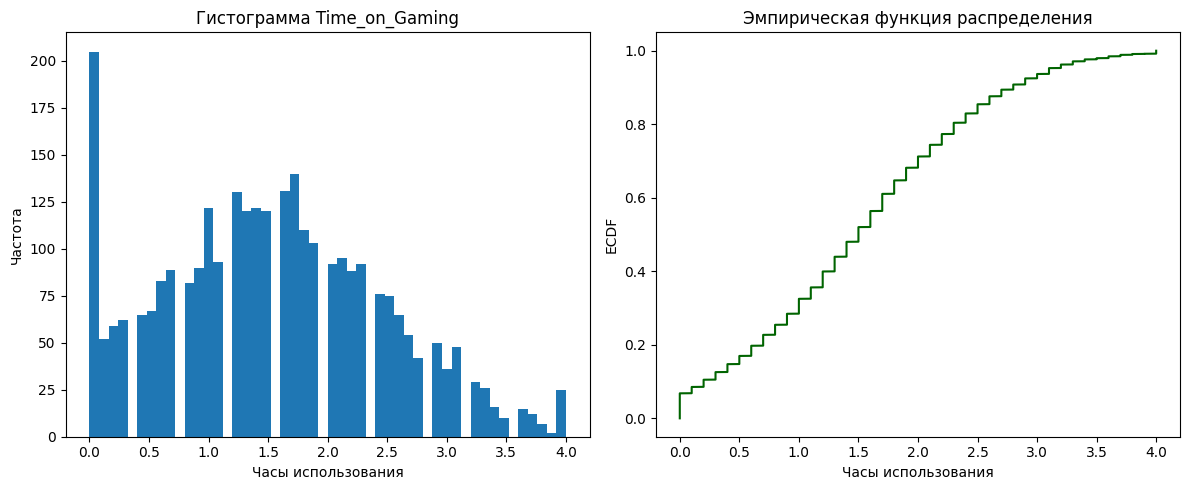

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_series, bins = 50)
plt.title(f'Гистограмма {col_name}')
plt.xlabel('Часы использования')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_series)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkgreen')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы использования')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

Критерий Хи квадрат

In [5]:
mean = data_series.mean()
std = np.sqrt(data_series.var())
n = len(data_series)

In [6]:
#Разбиваем данные на интервалы
bins = 10
hist, bin_edges = np.histogram(data_series, bins = bins, density=False)
observed = hist

In [7]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [8]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [9]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [10]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 301.02
Критическое значение (alpha=0.05, df=7): 14.07
Отвергаем гипотезу о нормальности (данные не нормальны)


Q-Q Plot

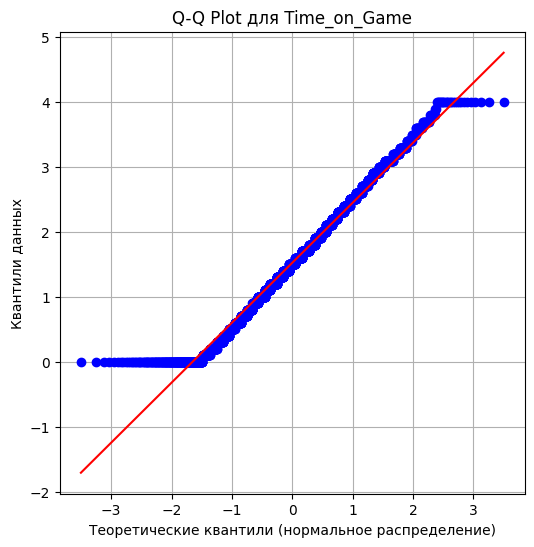

In [26]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))  # Размер графика
probplot(data_series, dist='norm', plot=plt)
plt.title('Q-Q Plot для Time_on_Game')
plt.xlabel('Теоретические квантили (нормальное распределение)')
plt.ylabel('Квантили данных')
plt.grid(True)
plt.show()

In [12]:
data_series.isna().sum()

np.int64(0)

Приведение данных к норм распределение через удаление выбросов

In [13]:
Q1 = data_series.quantile(0.25)
Q3 = data_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR) 
upper_bound = Q3 + 1.5 * IQR 

In [18]:
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {((data_series < lower_bound) | (data_series > upper_bound)).sum()} из {len(data_series)}")

Q1: 0.80, Q3: 2.20, IQR: 1.40
Границы выбросов: [0.00, 4.30]
Количество выбросов: 0 из 3000


In [14]:
filtered_series = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]

In [15]:
data_stand = (filtered_series - mean) / std

Характеристики после стандартизирования данных

In [16]:
print("Среднее значение", data_stand.mean())
print("Дисперсия", data_stand.var())
print("Мода", data_stand.mode()[0] if not data_stand.mode().empty else np.nan)
print("Медиана", data_stand.median())
quantilies_stand = data_stand.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_stand, bias=False))
print("Ассиметрия", stats.skew(data_stand, bias=False))
print("Интерквартильный размах", quantilies_stand[0.75] - quantilies_stand[0.25])

Среднее значение 3.7125857943465233e-16
Дисперсия 1.0
Мода -1.6353218242469598
Медиана -0.02708977540056775
Квантили [0.8 1.5 2.2]
Эксцесс -0.4982063569471826
Ассиметрия 0.25901081813568805
Интерквартильный размах 1.5010165789232994


Можно сделать вывод, что распределение данных после обработки чрезвычайно близко к стандартному нормальному N(0,1): его центр (Среднее примерно 0) и дисперсия (1.0) идеально соответствуют параметрам стандартного нормального распределения. Небольшие отклонения от идеала, такие как ненулевая асимметрия (0.26), указывающая на слабый правый скос, и отрицательный эксцесс (-0.50), свидетельствующий о более "приплюснутом" пике, являются минимальными, что позволяет считать данные эффективно нормально распределёнными для большинства дальнейших статистических процедур.

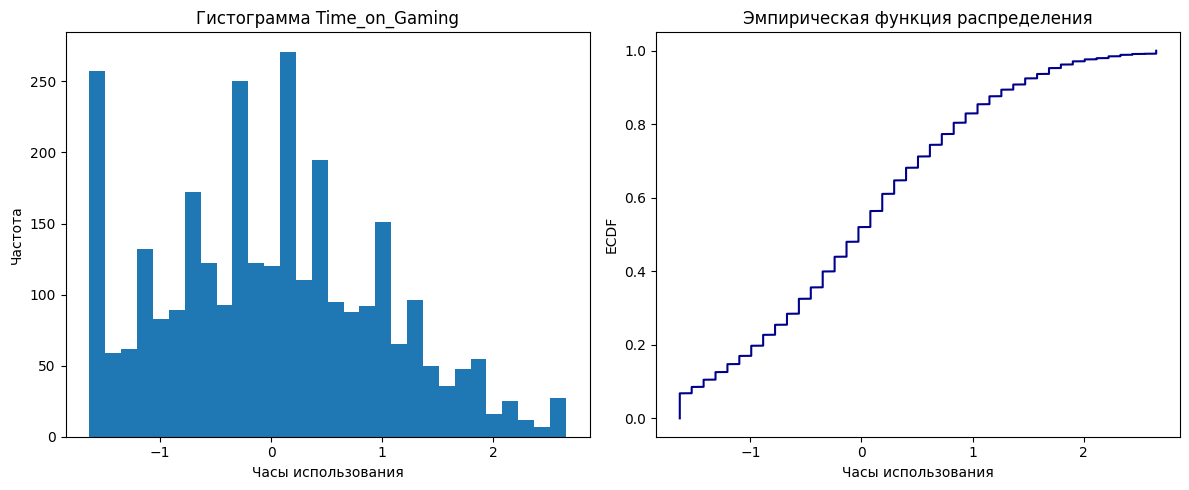

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_stand, bins = 30)
plt.title(f'Гистограмма {col_name}')
plt.xlabel('Часы использования')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_stand)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkblue')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы использования')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

In [18]:
mean = data_stand.mean()
std = np.sqrt(data_stand.var())
n = len(data_stand)

In [19]:
#Разбиваем данные на интервалы
bins = 10
hist, bin_edges = np.histogram(data_stand, bins = bins, density=False)
observed = hist #наблюдаемые частоты

In [20]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [21]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [22]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [23]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 280.97
Критическое значение (alpha=0.05, df=7): 14.07
Отвергаем гипотезу о нормальности (данные не нормальны)


In [24]:
grouped = df.groupby('School_Grade')['Daily_Usage_Hours']
stats_value = grouped.agg(['mean','var']).round(2)
print('Среднее и дисперсия по группам:')
print(stats_value)


Среднее и дисперсия по группам:
              mean   var
School_Grade            
10th          4.98  3.81
11th          5.06  3.64
12th          4.94  3.74
7th           5.08  3.88
8th           5.07  4.01
9th           5.01  3.91


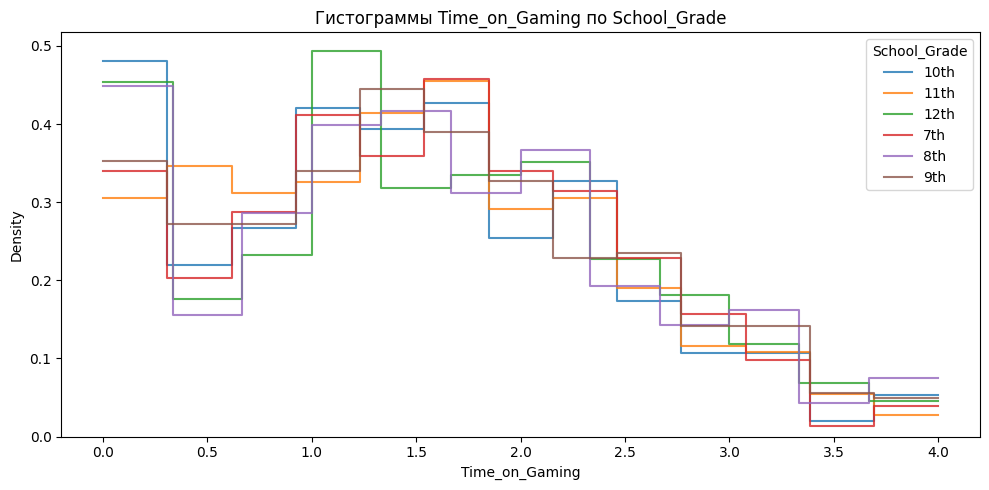

In [25]:
import seaborn as sns

unique_grades = sorted(df['School_Grade'].dropna().unique())
colors = sns.color_palette('tab10', n_colors=len(unique_grades))

plt.figure(figsize=(10, 5))
for c, g in zip(colors, unique_grades):
    vals = df.loc[df['School_Grade'] == g, col_name].dropna().astype(float)
    sns.histplot(vals, bins='auto', stat='density', kde=False, element='step', fill=False, color=c, label=str(g), alpha=0.8)
plt.title(f'Гистограммы {col_name} по School_Grade')
plt.xlabel(col_name)
plt.legend(title='School_Grade')
plt.tight_layout(); plt.show()
